In [ ]:
!pip install datasets
!pip install -U accelerate
!pip install -U transformers
!pip install evaluate
!pip install google-colab

from IPython.display import clear_output
from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments
from transformers import Trainer
import numpy as np
import evaluate
import matplotlib.pyplot as plt
from transformers import TrainerCallback, TrainerControl, TrainerState
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
import google.colab
import math
import torch
import pandas as pd

In [ ]:
drive = google.colab.drive.mount('/content/drive')
path = '/content/drive/MyDrive/ECE1786/'

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)


class ComputeTrainMetricsCallback(TrainerCallback):
    def __init__(self, trainer=None):
        super().__init__()
        self.trainer = trainer
        self.train_accuracy = []
        self.eval_accuracy = []
        self.train_loss = []
        self.eval_loss = []

    def on_epoch_end(self, args, state: TrainerState, control: TrainerControl, **kwargs):
        if self.trainer is None:
            raise ValueError("Trainer not set for ComputeTrainMetricsCallback")

        # Making predictions on the training dataset
        train_preds = self.trainer.predict(self.trainer.train_dataset)
        eval_preds = self.trainer.predict(self.trainer.eval_dataset)

        # Calculate accuracy
        train_labels = train_preds.label_ids
        train_loss = log_loss(train_labels, train_preds.predictions, labels=train_labels)
        train_preds = np.argmax(train_preds.predictions, axis=1)
        train_accuracy = accuracy_score(train_labels, train_preds)

        eval_labels = eval_preds.label_ids
        eval_loss = log_loss(eval_labels, eval_preds.predictions, labels=eval_labels)
        eval_preds = np.argmax(eval_preds.predictions, axis=1)
        eval_accuracy = accuracy_score(eval_labels, eval_preds)

        self.train_accuracy.append(train_accuracy)
        self.eval_accuracy.append(eval_accuracy)

        self.train_loss.append(train_loss)
        self.eval_loss.append(eval_loss)

def tokenize_function(examples):
    return tokenizer(examples["sample"], padding="max_length", truncation=True)

def trainEval(ds, tokenizer, model, metric, epchs, numClass, dataName, output_dir, trainP, valP, testP):

  ds = ds.shuffle()

  tokenizer.pad_token = tokenizer.eos_token
  model.config.pad_token_id = model.config.eos_token_id


  tokenized_datasets = ds.map(tokenize_function, batched=True)

  small_train_dataset = tokenized_datasets["train"].select(range(math.floor(trainP*len((ds["train"]["sample"])))))
  small_eval_dataset = tokenized_datasets["train"].select(range(math.floor(trainP*len((ds["train"]["sample"]))), math.floor((trainP+valP)*len((ds["train"]["sample"])))))
  small_test_dataset = tokenized_datasets["train"].select(range(math.floor((trainP+valP)*len((ds["train"]["sample"]))), len((ds["train"]["sample"]))))
  testSet = small_test_dataset

  training_args = TrainingArguments(
      output_dir=output_dir,
      num_train_epochs=epchs,
      evaluation_strategy="epoch")

  trainer = Trainer(
      model=model,
      args=training_args,
      train_dataset=small_train_dataset,
      eval_dataset=small_eval_dataset,
      compute_metrics=compute_metrics,
  )

  train_metrics_callback = ComputeTrainMetricsCallback(trainer=trainer)
  trainer.add_callback(train_metrics_callback)

  trainer.train()

  return trainer, train_metrics_callback, testSet

In [ ]:
def myPred(model, tokenizer, sample):
  df = pd.DataFrame({'sample': sample})
  df.to_csv(path+'testSample.csv', index=False)
  ds = load_dataset('csv', data_files=path+'testSample.csv')
  model.eval()
  tokenizer.pad_token = tokenizer.eos_token
  model.config.pad_token_id = model.config.eos_token_id

  tokenized_datasets = ds.map(tokenize_function, batched=False)

  testExample = tokenized_datasets["train"]
  testExample_preds = trainer.predict(testExample)
  testExample_preds = np.argmax(testExample_preds.predictions, axis=1)
  return testExample_preds

In [ ]:
def testAccuracy(testSet, model):
  model.config.pad_token_id = model.config.eos_token_id

  trainer = Trainer(
      model=model,
      eval_dataset=testSet,
      compute_metrics=compute_metrics
  )

  eval_preds = trainer.predict(trainer.eval_dataset)

  eval_labels = eval_preds.label_ids
  eval_loss = log_loss(eval_labels, eval_preds.predictions, labels=eval_labels)
  eval_preds = np.argmax(eval_preds.predictions, axis=1)
  eval_accuracy = accuracy_score(eval_labels, eval_preds)

  return eval_accuracy, eval_loss

In [ ]:
def plotTrainer(train_metrics_callback, numClass, dataName):

  epochs = range(1, len(train_metrics_callback.eval_accuracy) + 1)

  plt.plot(epochs, train_metrics_callback.train_accuracy, 'bo-', label='Training accuracy')
  plt.plot(epochs, train_metrics_callback.eval_accuracy, 'ro-', label='Validation accuracy')
  plt.title('Training and Validation Accuracy for '+ str(numClass)+ '-class '+ dataName)
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.show()

  epochs = range(1, len(train_metrics_callback.eval_accuracy) + 1)

  plt.plot(epochs, train_metrics_callback.train_loss, 'bo-', label='Training loss')
  plt.plot(epochs, train_metrics_callback.eval_loss, 'ro-', label='Validation loss')
  plt.title('Training and Validation Loss for '+ str(numClass)+ '-class '+ dataName)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.show()

# Cleaned Final dataset

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/431 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.051781,0.488372
2,No log,1.020622,0.476744
3,No log,0.842943,0.627907
4,No log,0.756056,0.639535
5,No log,0.809791,0.709302
6,No log,1.032703,0.709302
7,No log,0.739715,0.790698
8,No log,0.907492,0.790698
9,No log,0.973840,0.813953
10,No log,0.983941,0.813953


Test Accuracy:  0.7045454545454546
Test Loss:  1.8266500320016663


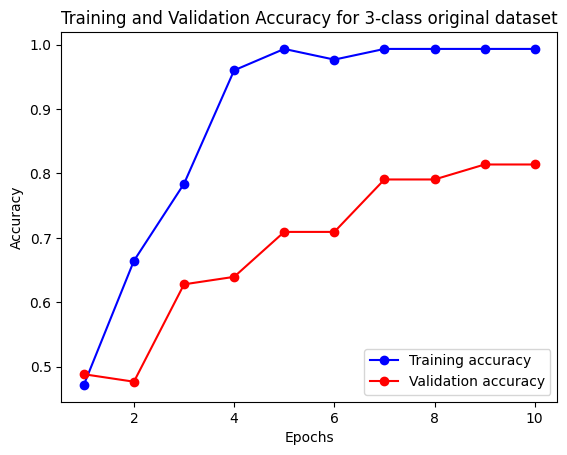

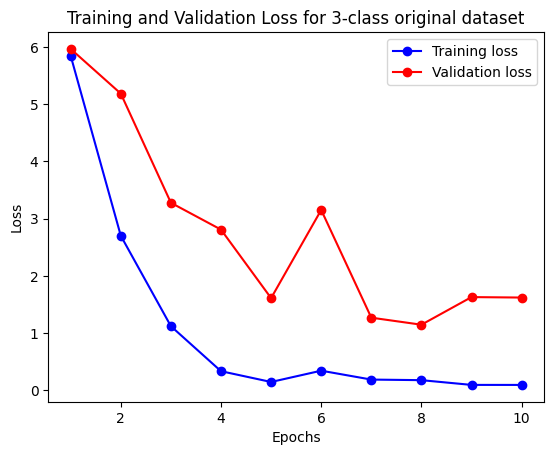

In [ ]:
ds = load_dataset('csv', data_files=path+'cleaned-final-dataset.csv')
numClass = 3
tokenizer = AutoTokenizer.from_pretrained("gpt2")
model = AutoModelForSequenceClassification.from_pretrained("gpt2", num_labels=numClass)
metric = evaluate.load("accuracy")
numEpochs = 10
dataName = 'original dataset'
output_dir = "/content/test_trainer"
trainP, valP, testP = 0.7, 0.2, 0.1

trainer, train_metrics_callback, testSet = trainEval(ds, tokenizer, model, metric, numEpochs, numClass, dataName, output_dir, trainP, valP, testP)
trainer.save_model(path)
testAcc, testLoss = testAccuracy(testSet, model)
print('Test Accuracy: ', testAcc)
print('Test Loss: ', testLoss)
plotTrainer(train_metrics_callback, numClass, dataName)

# Test Accuracy and loss

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(path)
testAcc, testLoss = testAccuracy(testSet, model)
print('Test Accuracy: ', testAcc)
print('Test Loss: ', testLoss)

Test Accuracy:  0.7045454545454546
Test Loss:  1.8266500320016663


# Test for an example

In [ ]:
sample = ["I had to take a ferry to reach Barrie as it's located on an island.  Collingwood is a town in Simcoe County, Ontario, Canada. Merritt has dozens of bronzed hand prints of country music stars who have been in Merritt for the annual Merritt Mountain Music Festival displayed throughout town."]
model = AutoModelForSequenceClassification.from_pretrained(path)
tokenizer = AutoTokenizer.from_pretrained("gpt2")

output = myPred(model, tokenizer, sample)
output[0]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

0